# Utils

In [19]:
def path_cost(path : list, weights : dict, cycle=True) -> int:
    """Computes the cost of the given path

    Args:
        path (list): tour taken\n
        weights (dict): key -> edge : value -> weight.\n
        cycle (bool, optional): [description]. Defaults to True.\n

    Returns:
        int: final cost
    """
    cost = 0
    for i in range(len(path) - 1):
        try:
            if (path[i], path[i + 1]) in weights.keys():
                cost += weights[(path[i],path[i+1])]
            else:
                cost += weights[(path[i + 1],path[i])]
        except:
            if cycle:
                if (path[i], path[0]) in weights.keys():
                    cost += weights[(path[i], path[0])]
                else:
                    cost += weights[(path[0], path[i])]
                pass
    return cost


In [20]:
import math
def compute_distance(a, b):
    a = a['pos']
    b = b['pos']
    return math.sqrt(math.pow(a[0]-b[0],2) + math.pow(a[1]-b[1],2))


In [21]:
from graph import MyGraph
import torch
import os
from plotly.subplots import make_subplots
from functools import partial

def create_graph_fittizio(
     name : str,
     dir : str,
     lb : int = 0,
     ub : int = 100,
     n_nodes : int = 50,
     #normalized : bool = False,
     count : int = 0
    ):
    G = nx.Graph()
    V = set([v + 1 for v in range(n_nodes)])
    
    E = set()
    for combination in combinations(V, 2):
        E.add(combination)
    coords = []
    to_normalize_location = []
    max_coord = 0
    for i in range(1,n_nodes + 1):
        location = (random.randint(lb,ub), random.randint(lb,ub))
        if location[0] > max_coord:
            max_coord = location[0]
        elif location[1] > max_coord:
            max_coord = location[1]
        to_normalize_location.append(location)
    #print(to_normalize_location)
    for i, location in enumerate(to_normalize_location):
        normalized_location = (location[0]/max_coord, location[1]/max_coord)
        #print(normalized_location)
        coords.append(normalized_location)
        G.add_node(i+1, pos = normalized_location)
    coords = torch.Tensor(coords)
    for edge in E:
        w = compute_distance(G.nodes[edge[0]], G.nodes[edge[1]])
        #print(edge[0], edge[1], w)
        G.add_edge(edge[0], edge[1], weight = w)
    
    tsp = nx.approximation.traveling_salesman_problem
    path = tsp(G, cycle=True)
    if len(path) > 51:
        return count
    path = np.array(path)
    w_dic = {}
    for i in range(1, 51):
        for j in range(1,51):
            if i != j:
                w_dic[(i,j)] = compute_distance(G.nodes[i], G.nodes[j])
    #print(w_dic)
    cost = path_cost(path, weights = w_dic)
    #print(path, cost)
    

    #TODO salvare i grafi creati
    g = MyGraph(name + '.mio', nodes = G.nodes(), coords = coords,weights = w_dic, sub_opt = path, sub_opt_cost= cost)
    #print(len(path))
    
    path_to_save = os.path.join(dir, name)
    torch.save(g, path_to_save)
    return (count + 1, g)

In [22]:
import networkx as nx
import numpy as np
import random
from itertools import combinations

def get_weight(a, b):
    a = a['pos']
    b = b['pos']
    return int(np.sqrt((a[0]-b[0])**2 + (b[1]-a[1])**2))



# Generate graph

In [23]:
from utility import create_dir
import pandas as pd
name_dir = 'plots'
create_dir(name_dir)
count = 0
graphs = []
while count < 10:
    count, g = create_graph_fittizio(f'{name_dir}_' + str(count) + '.mio', name_dir, ub = 1000, count = count)
    graphs.append(g)

# Plot

In [24]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def get_tour_coords(tour, coords, n_nodes = 50):
    ret = np.zeros((n_nodes+1,2))
    for i, node in enumerate(tour):
        ret[i] = coords[node-1]
    return ret

def create_arrows(coords, color='red'):
    arrows = [go.layout.Annotation(dict(
                x= coords[i+1,0],
                y= coords[i+1,1],
                xref="x", yref="y",
                text="",
                showarrow=True,
                axref = "x", ayref='y',
                ax= coords[i,0],
                ay= coords[i,1],
                arrowhead = 3,
                arrowwidth=1.5,
                arrowcolor=color,)
            ) for i in range(50)]
    return arrows

for g in graphs:   #grafi per cui fare il confronto
    df = pd.DataFrame(g.coords) #coordinate del grafo
    nodes = go.Scatter(
        x=df[0],
        y=df[1],
        mode='markers',
        marker=dict(
            color='rgb(34,163,192)'
                   )
    )

    fig = make_subplots()
    fig.add_trace(nodes)
    fig['layout'].update(height = 600, width = 800, title = 'Example',xaxis=dict(tickangle=-90))

    gt_coords = get_tour_coords(g.get_sub_opt, g.coords) #ottengo un tensore 51,2 di coordinate ordinate in base al tour ottenuto
    fig.update_layout(annotations=create_arrows(gt_coords, color='red'),) #creo tutte le frecce da aggiungere al plot e le aggiungo
    #output_coords = get_tour_coords(output_tour, g.coords) #ripetere lo step però con il tour della rete
    #fig.update_layout(annotations=create_arrows(output_coords),)
    fig.show()

In [25]:
for i in range(10000):
    x = torch.load(f'{name_dir}/{name_dir}_{i}.mio')
    if (len(x.sub_opt)) > 51:
        print(x.sub_opt_cost)
        print(x.coords)


FileNotFoundError: [Errno 2] No such file or directory: 'plots/plots_10.mio'

In [ ]:
from utility import create_dir
name_dir = 'generated_eval'
create_dir(name_dir)
count = 0
while count < 5000:
    count = create_graph_fittizio(f'{name_dir}_' + str(count) + '.mio', name_dir, ub = 1000, count = count)

In [ ]:
for i in range(5000):
    x = torch.load(f'{name_dir}/{name_dir}_{i}.mio')
    if (len(x.sub_opt)) != 51 or (x.sub_opt_cost > 8):
        print(i)
        print(x.coords.shape)
        print(x.coords)
        print(x.nodes)


# Get model

In [ ]:
from types import SimpleNamespace
from training.utility import get_model
import torch

model_args = SimpleNamespace(**{
    'model': 'custom',
    'add_cross_attn': True,
    'use_q_proj_ca': False,
    'use_feedforward_block_sa': False,
    'clip_logit_c': None,
    'device': 'cpu',
    'in_features': 2,
    'nhead': 4,
    'norm_eps': 1e-5,
    'dropout_p': 0.,
    'sinkhorn_i': 20,
    'positional_encoding': 'sin',
    'num_hidden_encoder_layers': 2,
    'd_model': 128,
    'dim_feedforward': 512,
    'activation': 'relu',
    'norm': 'custom_batch',
    'sinkhorn_tau': 0.02,
    'use_feedforward_block_ca': True,
    # 'resume_from_checkpoint': "/Users/david/git/adm-project/checkpoints/best/custom/simple_checkpoint_16.pt",
})

def get_model_from_checkpoint(model_args, checkpoint):
    model = get_model(model_args)
    model.load_state_dict(torch.load(checkpoint)['model'])
    return model

model = get_model(model_args)
model.load_state_dict(torch.load('checkpoints/best/custom/simple_checkpoint_16.pt')['model'])
# model.load_state_dict(torch.load('/Users/david/git/adm-project/checkpoints/best/custom/simpe_no_h_checkpoint_20.pt')['model'])
model.eval()
model.training

False

# Plot - comparison ours vs nx

In [ ]:
import torch
import os
import numpy as np

try:
    graphs
except NameError:
    graphs = [torch.load(x.path) for x in os.scandir('plots') if x.is_file()]

print(len(graphs))

10


In [44]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def get_tour_coords(tour, coords, n_nodes = 50):
    ret = np.zeros((n_nodes+1,2))
    for i, node in enumerate(tour):
        ret[i] = coords[node-1]
    return ret

def create_arrows(coords, color='red', xref="x", yref="y"):
    arrows = [go.layout.Annotation(dict(
                x= coords[i+1,0],
                y= coords[i+1,1],
                xref=xref, yref=yref,
                text="",
                showarrow=True,
                axref=xref, ayref=yref,
                ax= coords[i,0],
                ay= coords[i,1],
                arrowhead = 3,
                arrowwidth=1.5,
                arrowcolor=color,)
            ) for i in range(50)]
    return arrows

for g in graphs:   #grafi per cui fare il confronto
    model_input = g.coords
    with torch.no_grad():
        model_tour = model(model_input.unsqueeze(0)).tour

    nx_tour_coords = g.coords[g.get_sub_opt - 1]
    # nx_tour_coords = get_tour_coords(g.get_sub_opt, g.coords)
    model_tour_coords = g.coords[model_tour.squeeze()]

    df = pd.DataFrame(g.coords)

    nodes = go.Scatter(
        x=df[0],
        y=df[1],
        mode='markers',
        marker=dict(
            color='red'
                   )
    )

    fig = make_subplots(1, 2, subplot_titles=['Christofides', 'Ours'])
    fig.add_trace(nodes, 1, 1)
    fig.add_trace(nodes, 1, 2)



    # This doesn't work...
    # fig.update_layout(
    #     annotations=[
    #         *create_arrows(model_tour_coords, color='blue', xref='x', yref='y'),
    #         *create_arrows(nx_tour_coords, color='green', xref='x2', yref='y2')
    #     ]
    # )

    for ann in create_arrows(nx_tour_coords, color='blue', xref='x', yref='y'):
        fig.add_annotation(ann)
    for ann in create_arrows(model_tour_coords, color='green', xref='x2', yref='y2'):
        fig.add_annotation(ann)

    
    # highlight starting node
        start_nx = go.Scatter(
        x=nx_tour_coords[0:1, 0],
        y=nx_tour_coords[0:1, 1],
        mode='markers',
        marker_symbol='hexagram',
        marker=dict(
            color='red',
            size=12,
        )
    )
    start_model = go.Scatter(
        x=model_tour_coords[0:1, 0],
        y=model_tour_coords[0:1, 1],
        mode='markers',
        marker_symbol='hexagram',
        marker=dict(
            color='red',
            size=12,
        )
    )

    fig.add_trace(start_nx, 1, 1)
    fig.add_trace(start_model, 1, 2)
    
    fig.update(layout_showlegend=False)

    fig.show()

# Plot - comparison ours vs ours + custom ILS

In [45]:
import torch
import os
import numpy as np

top_ils = {
    'normalized_1767.mio',
    'normalized_9311.mio',
    'normalized_6913.mio',
    'normalized_9631.mio',
    'normalized_9318.mio',
    'normalized_8528.mio',
    'normalized_6404.mio',
    'normalized_5621.mio',
    'normalized_2076.mio',
    'normalized_7704.mio'
}

ils_graphs = [torch.load(os.path.join('ALL_tsp/generated_test/normalized', x)) for x in top_ils]

print(len(ils_graphs))

10


In [47]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from training.utility import tour_len_ils_batch
from dataset import BatchGraphInput


def get_tour_coords(tour, coords, n_nodes = 50):
    ret = np.zeros((n_nodes+1,2))
    for i, node in enumerate(tour):
        ret[i] = coords[node-1]
    return ret

def create_arrows(coords, color='red', xref="x", yref="y"):
    arrows = [go.layout.Annotation(dict(
                x= coords[i+1,0],
                y= coords[i+1,1],
                xref=xref, yref=yref,
                text="",
                showarrow=True,
                axref=xref, ayref=yref,
                ax= coords[i,0],
                ay= coords[i,1],
                arrowhead = 3,
                arrowwidth=1.5,
                arrowcolor=color,)
            ) for i in range(50)]
    return arrows

for g in ils_graphs:   #grafi per cui fare il confronto
    model_input = g.coords
    with torch.no_grad():
        model_out = model(model_input.unsqueeze(0))

    model_tour_coords = g.coords[model_out.tour.squeeze()]
    batch = BatchGraphInput(g.coords.unsqueeze(0), None, None)
    ils_tour, ils_len = tour_len_ils_batch(model_out, batch, 5, 10, 5)
    ils_tour = ils_tour.squeeze()
    ils_tour_coords = g.coords[ils_tour]


    df = pd.DataFrame(g.coords)

    nodes = go.Scatter(
        x=df[0],
        y=df[1],
        mode='markers',
        marker=dict(
            color='red'
                   )
    )


    fig = make_subplots(1, 2, subplot_titles=['Our model', 'Our ILS k=5'])
    fig.add_trace(nodes, 1, 1)
    fig.add_trace(nodes, 1, 2)

    # this doesn't work...
    # fig.update_layout(
    #     annotations=[
    #         *create_arrows(model_tour_coords, color='blue', xref='x', yref='y'),
    #         *create_arrows(ils_tour_coords, color='green', xref='x2', yref='y2')
    #     ]
    # )

    for ann in create_arrows(model_tour_coords, color='blue', xref='x', yref='y'):
        fig.add_annotation(ann)
    for ann in create_arrows(ils_tour_coords, color='green', xref='x2', yref='y2'):
        fig.add_annotation(ann)

    start_model = go.Scatter(
        x=model_tour_coords[0:1, 0],
        y=model_tour_coords[0:1, 1],
        mode='markers',
        marker_symbol='hexagram',
        marker=dict(
            color='red',
            size=12,
        )
    )

    start_ils = go.Scatter(
        x=ils_tour_coords[0:1, 0],
        y=ils_tour_coords[0:1, 1],
        mode='markers',
        marker_symbol='hexagram',
        marker=dict(
            color='red',
            size=12,
        )
    )

    fig.add_trace(start_model, 1, 1)
    fig.add_trace(start_ils, 1, 2)

    fig.update(layout_showlegend=False)

    fig.show()

# Attn matrix

In [48]:
from plotly.subplots import make_subplots
import plotly.express as px

def attn_matrix2img(attn_matrix):
    if type(attn_matrix) == torch.Tensor:
        attn_matrix = attn_matrix.squeeze().cpu().numpy()
    return ((attn_matrix - attn_matrix.min(axis=1).reshape(-1, 1)) / (attn_matrix.max(axis=1).reshape(-1, 1) - attn_matrix.min(axis=1).reshape(-1, 1)) * 255).astype(np.uint8)

# model_in = graphs[3].coords
# with torch.no_grad():
#     model_out = model(model_in.unsqueeze(0)) 
# img = attn_matrix2img(model_out.attn_matrix)
# fig = px.imshow(img)
# fig.show()

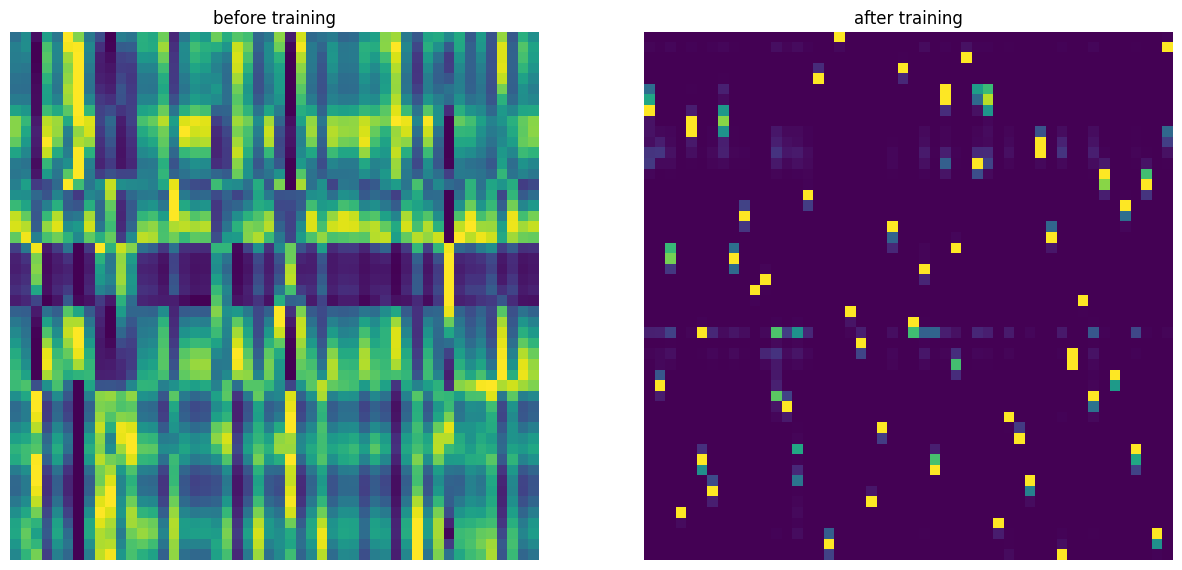

In [49]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

model_in = graphs[3].coords
model_train = get_model_from_checkpoint(model_args, '/Users/david/git/adm-project/checkpoints/best/custom/simple_checkpoint_16.pt')
model_no_train = get_model(model_args)
with torch.no_grad():
    model_out_no_train = model_no_train(model_in.unsqueeze(0)) 
    model_out_train = model_train(model_in.unsqueeze(0)) 
img_no_train = attn_matrix2img(model_out_no_train.attn_matrix)
img_train = attn_matrix2img(model_out_train.attn_matrix)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.imshow(img_no_train)
ax.set_title('before training')
ax1 = fig.add_subplot(1,2,2)
ax1.imshow(img_train)
ax1.set_title('after training')
ax.set_axis_off()
ax1.set_axis_off()